## Toy MC plots for the paper
----------
Generates those plots that are used in the final version of the paper. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ultrasurfaces_paper_plotstyle.mplstyle")

from toy_mc import generator
from importlib import reload

In [2]:
delta_msq_31 = 2.515e-3
sinsq_theta_23 = 0.565
# convert this to sin**2(2 \theta)
theta_23 = np.arcsin(np.sqrt(sinsq_theta_23))
sinsq_2theta_23 = np.sin(2 * theta_23)**2
default_pars = generator.OscPars(delta_msq_31, sinsq_2theta_23)

default_response = generator.Response(1., 0.08)

bin_edges = np.logspace(1., 2., 26)

In [3]:
gen = generator.Generator(int(1e5), default_response, default_pars)
h0 = gen.get_histogram(bin_edges)
h0_true = gen.get_histogram(bin_edges, variable="true_energy")

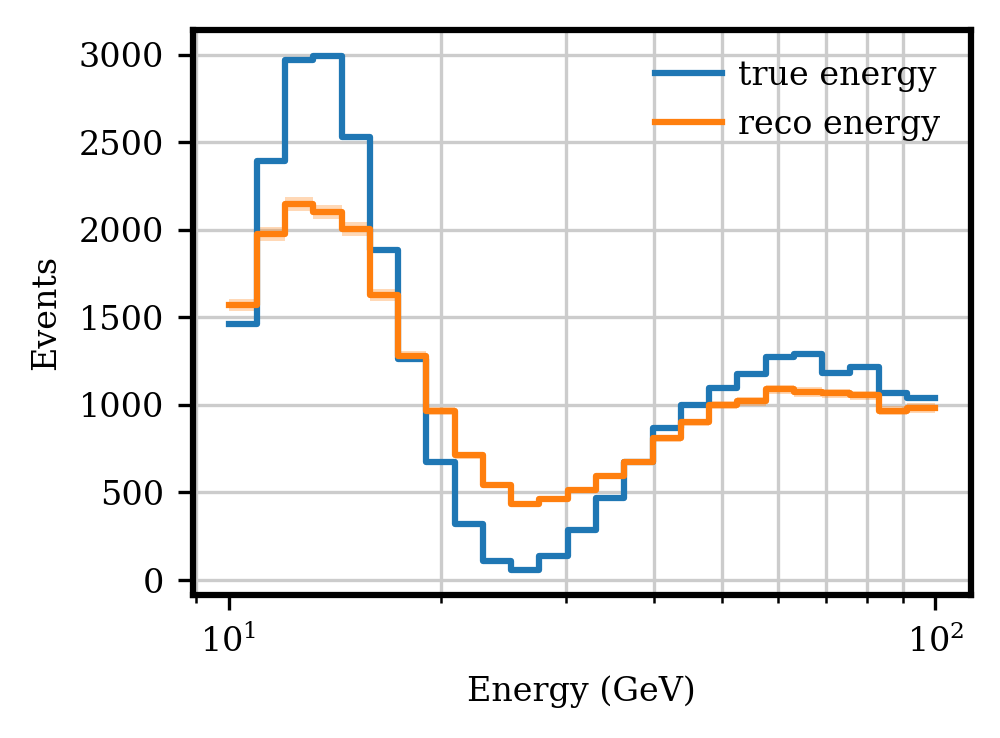

In [4]:
from toy_mc.histogram import plot_histogram

fig, ax = plt.subplots()
plot_histogram(h0_true, ax=ax, show_errorband=False, label="true energy")
plot_histogram(h0, ax=ax, label="reco energy")
# plt.minorticks_on()
plt.semilogx()
plt.legend()
plt.grid(which="both", axis="x")
plt.xlabel("Energy (GeV)")
plt.ylabel("Events")
plt.tight_layout()
plt.savefig("plot_output/toy_mc_histogram_true_reco.pdf")
plt.show()

In [5]:
# Generate several sets at different values of mu
reload(generator)
gen_nominal = generator.Generator(
    int(1e5), default_response, default_pars, name="nominal", rng_seed=0
)
# It looks like there is a breakdown point where, if the response is *too* different,
# the whole thing doesn't work anymore.
gen_sys_1 = generator.Generator(
    int(1e5),
    generator.Response(1.05 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_01",
    rng_seed=0
)
gen_sys_2 = generator.Generator(
    int(1e5),
    generator.Response(0.95 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_02",
    rng_seed=0
)
gen_sys_3 = generator.Generator(
    int(1e5),
    generator.Response(0.975 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_03",
    rng_seed=0
)
gen_sys_4 = generator.Generator(
    int(1e5),
    generator.Response(1.025 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_04",
    rng_seed=0
)

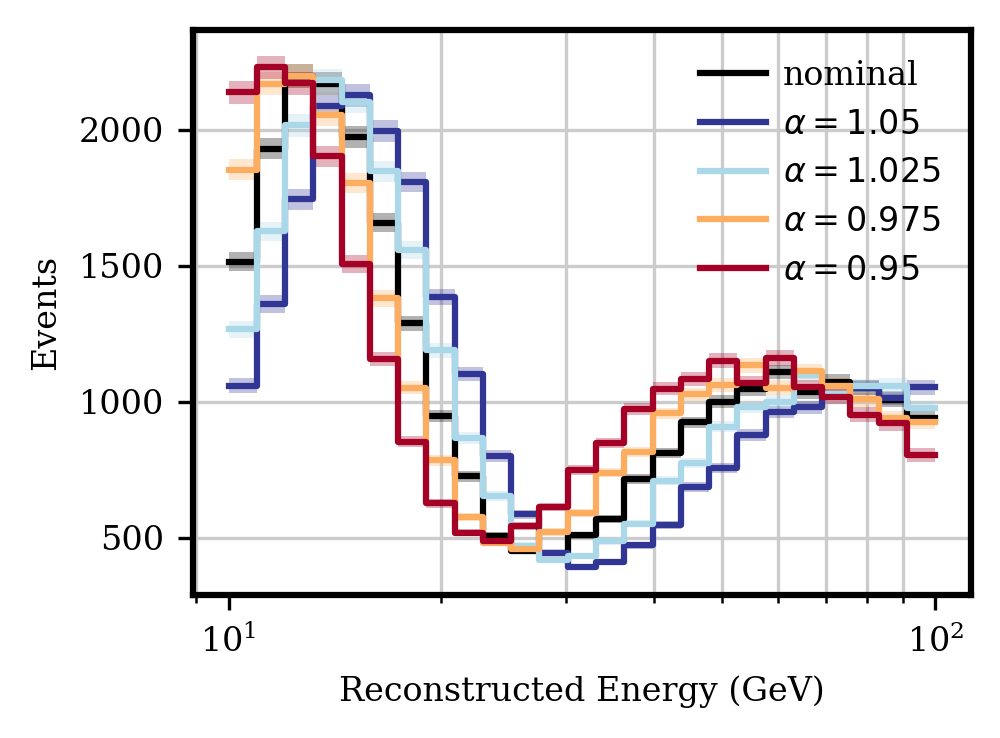

In [9]:
from toy_mc.histogram import plot_histogram

fig, ax = plt.subplots()
# write alpha instead of mu in the legend because we write that in the paper
plot_histogram(gen_nominal.get_histogram(bin_edges), ax=ax, label="nominal", color="k")
# color each histogram with a colormap according to its alpha value
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("RdYlBu")

plot_histogram(gen_sys_1.get_histogram(bin_edges), ax=ax, label=r"$\alpha=1.05$", color=cmap(1.0))
plot_histogram(gen_sys_4.get_histogram(bin_edges), ax=ax, label=r"$\alpha=1.025$", color=cmap(0.7))
plot_histogram(gen_sys_3.get_histogram(bin_edges), ax=ax, label=r"$\alpha=0.975$", color=cmap(0.3))
plot_histogram(gen_sys_2.get_histogram(bin_edges), ax=ax, label=r"$\alpha=0.95$", color=cmap(0.0))
plt.semilogx()
plt.legend()
plt.grid(which="both", axis="x")
plt.xlabel("Reconstructed Energy (GeV)")
plt.ylabel("Events")
plt.tight_layout()
plt.savefig("plot_output/toy_mc_histogram_systematics.pdf")
plt.show()

### Apply KNN
Calculate class posterior probabilities using the (skew-corrected) KNN classifier

In [10]:
from surfaces import calculate_probs

df_with_probs = calculate_probs.calculate_probs_sklearn(
    gen_nominal,
    [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=200,
    jobs=4
)

Starting KNN evaluation...


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


In [11]:
df_with_probs

,true_energy,true_cos(zen),weights_pre_detector,reco_energy,weights,set,prob_nominal,prob_sys_01,prob_sys_02,prob_sys_03,prob_sys_04
0,23.060308,-1.0,0.052845,15.709762,0.052845,nominal,0.173538,0.081878,0.383046,0.233244,0.128293
1,17.137504,-1.0,0.524539,18.466420,0.524539,nominal,0.221976,0.224425,0.132008,0.173201,0.248390
2,41.707228,-1.0,0.326591,40.956423,0.326591,nominal,0.193507,0.173598,0.186492,0.253661,0.192742
3,22.513865,-1.0,0.070286,25.808697,0.070286,nominal,0.229847,0.253855,0.136364,0.155548,0.224386
4,10.768750,-1.0,0.654905,16.796014,0.654905,nominal,0.122988,0.507983,0.021841,0.050375,0.296813
...,...,...,...,...,...,...,...,...,...,...,...
99995,6.944873,-1.0,0.830246,7.473007,0.830246,nominal,0.245185,0.248172,0.111295,0.171629,0.223719
99996,1.388665,-1.0,0.299039,1.416954,0.299039,nominal,0.203561,0.244844,0.152449,0.178413,0.220733
99997,19.946151,-1.0,0.216703,16.917959,0.216703,nominal,0.213306,0.102212,0.257018,0.258728,0.168737
99998,5.646440,-1.0,0.379824,5.509054,0.379824,nominal,0.222433,0.162169,0.206237,0.213737,0.195424


### Calculate gradients
Calculate event-wise gradients by minimizing the log-likelihood.

In [12]:
from surfaces import calculate_grads

# get gradient names for systematic "mu"
grad_names = calculate_grads.make_gradient_names(["mu"], 2)
print(grad_names)
# make delta_p matrix for the systematic "mu" 
# (i.e. the detector response)
delta_p = calculate_grads.make_delta_p_from_grad_names(
    grad_names, [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4], gen_nominal
)
delta_p

['grad__mu', 'grad__mu__mu']


array([[ 0.      ,  0.05    , -0.05    , -0.025   ,  0.025   ],
       [ 0.      ,  0.0025  ,  0.0025  ,  0.000625,  0.000625]])

In [13]:
# Calculate the gradients
df_with_grads = calculate_grads.fit_gradients(
    df_with_probs, 
    prob_columns=["prob_nominal", "prob_sys_01", "prob_sys_02", "prob_sys_03", "prob_sys_04"], 
    delta_p=delta_p, 
    grad_names=grad_names
)

100%|██████████| 100000/100000 [01:01<00:00, 1630.82it/s]


In [14]:
df_with_grads

,true_energy,true_cos(zen),weights_pre_detector,reco_energy,weights,set,prob_nominal,prob_sys_01,prob_sys_02,prob_sys_03,prob_sys_04,grad__mu,grad__mu__mu
0,23.060308,-1.0,0.052845,15.709762,0.052845,nominal,0.173538,0.081878,0.383046,0.233244,0.128293,-14.636246,27.266209
1,17.137504,-1.0,0.524539,18.466420,0.524539,nominal,0.221976,0.224425,0.132008,0.173201,0.248390,5.757769,-105.284851
2,41.707228,-1.0,0.326591,40.956423,0.326591,nominal,0.193507,0.173598,0.186492,0.253661,0.192742,-1.842734,-67.261367
3,22.513865,-1.0,0.070286,25.808697,0.070286,nominal,0.229847,0.253855,0.136364,0.155548,0.224386,6.442168,-54.565623
4,10.768750,-1.0,0.654905,16.796014,0.654905,nominal,0.122988,0.507983,0.021841,0.050375,0.296813,33.170784,-120.848218
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,6.944873,-1.0,0.830246,7.473007,0.830246,nominal,0.245185,0.248172,0.111295,0.171629,0.223719,7.371184,-123.496007
99996,1.388665,-1.0,0.299039,1.416954,0.299039,nominal,0.203561,0.244844,0.152449,0.178413,0.220733,4.646272,-17.733564
99997,19.946151,-1.0,0.216703,16.917959,0.216703,nominal,0.213306,0.102212,0.257018,0.258728,0.168737,-9.051968,-118.612482
99998,5.646440,-1.0,0.379824,5.509054,0.379824,nominal,0.222433,0.162169,0.206237,0.213737,0.195424,-2.269489,-70.419363


-79.58341437381756 32.88588752538764


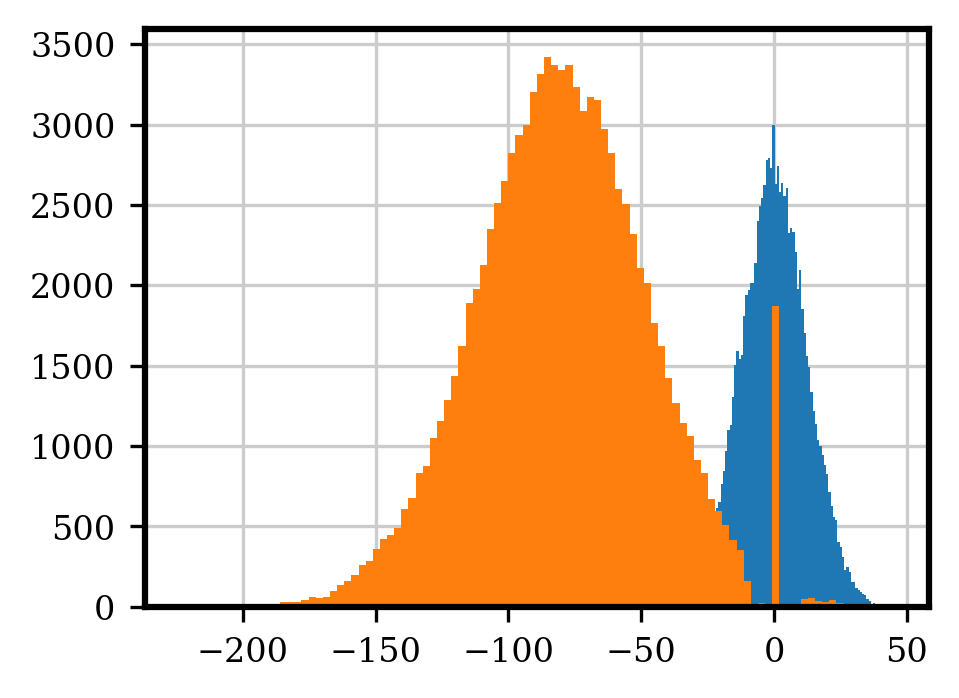

In [15]:
plt.hist(df_with_grads["grad__mu"], bins=100)
plt.hist(df_with_grads["grad__mu__mu"], bins=100)
# print mean and standard deviation of second order gradient
print(np.mean(df_with_grads["grad__mu__mu"]), np.std(df_with_grads["grad__mu__mu"]))
plt.show()

In [16]:
df_with_grads[df_with_grads["grad__mu__mu"] >= 0.0]

,true_energy,true_cos(zen),weights_pre_detector,reco_energy,weights,set,prob_nominal,prob_sys_01,prob_sys_02,prob_sys_03,prob_sys_04,grad__mu,grad__mu__mu
0,23.060308,-1.0,0.052845,15.709762,0.052845,nominal,0.173538,0.081878,0.383046,0.233244,0.128293,-14.636246,27.266209
82,12.918683,-1.0,0.999967,18.695232,0.999967,nominal,0.148270,0.436200,0.052771,0.090155,0.272604,21.182740,0.308101
153,11.083802,-1.0,0.751489,6.631067,0.751489,nominal,0.120907,0.029949,0.530492,0.256938,0.061713,-28.930719,0.705047
278,4.536415,-1.0,0.804834,5.137638,0.804834,nominal,0.182002,0.337422,0.092690,0.151612,0.236275,11.917171,0.077606
303,0.259336,-1.0,0.916773,0.302681,0.916773,nominal,0.192979,0.209881,0.211716,0.184214,0.201210,0.256745,40.935940
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99106,10.997240,-1.0,0.726424,12.748672,0.726424,nominal,0.192883,0.300542,0.110688,0.189361,0.206526,8.072171,0.030810
99239,82.017379,-1.0,0.777545,200.485462,0.777545,nominal,0.128589,0.524258,0.030970,0.058569,0.257614,28.553195,0.639610
99473,9.815624,-1.0,0.303212,7.266194,0.303212,nominal,0.160647,0.060740,0.426224,0.261361,0.091028,-19.872115,0.304215
99698,32.271870,-1.0,0.108892,30.938290,0.108892,nominal,0.194352,0.196224,0.206275,0.209719,0.193430,-0.728103,0.012825


In [17]:
def plot_one_event(index, ax):
    probs = df_with_grads.loc[
        index,
        ["prob_nominal", "prob_sys_01", "prob_sys_02", "prob_sys_03", "prob_sys_04"],
    ].to_numpy()
    grads = df_with_grads.loc[index, grad_names].to_numpy(dtype=float)

    print(grads)

    delta_mu_plot = np.linspace(0.94, 1.06, 100) - 1
    predicted_probs = np.exp(grads[0] * delta_mu_plot + grads[1] * delta_mu_plot**2)

    mu_sets = [
        gen.detector_response.mu
        for gen in [gen_nominal, gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4]
    ]
    mu_sets = np.array(mu_sets)
    # Normalize the predicted probabilities over the sets
    pred_probs_sets = np.exp(np.dot(grads, np.asarray(delta_p)))
    set_normalization = np.sum(pred_probs_sets)

    pred_probs_sets = pred_probs_sets / set_normalization
    # We plot the interpolated probabilities with the same normalization
    # (in practice, we are only interested in ratios between sets and 
    # therefore the normalization is not important)
    predicted_probs = predicted_probs / set_normalization

    ax.plot(mu_sets, probs, "o", label="KNN probabilities")
    ax.plot(delta_mu_plot + 1, predicted_probs, label="best fit")


[-10.60007152 -71.08974597]


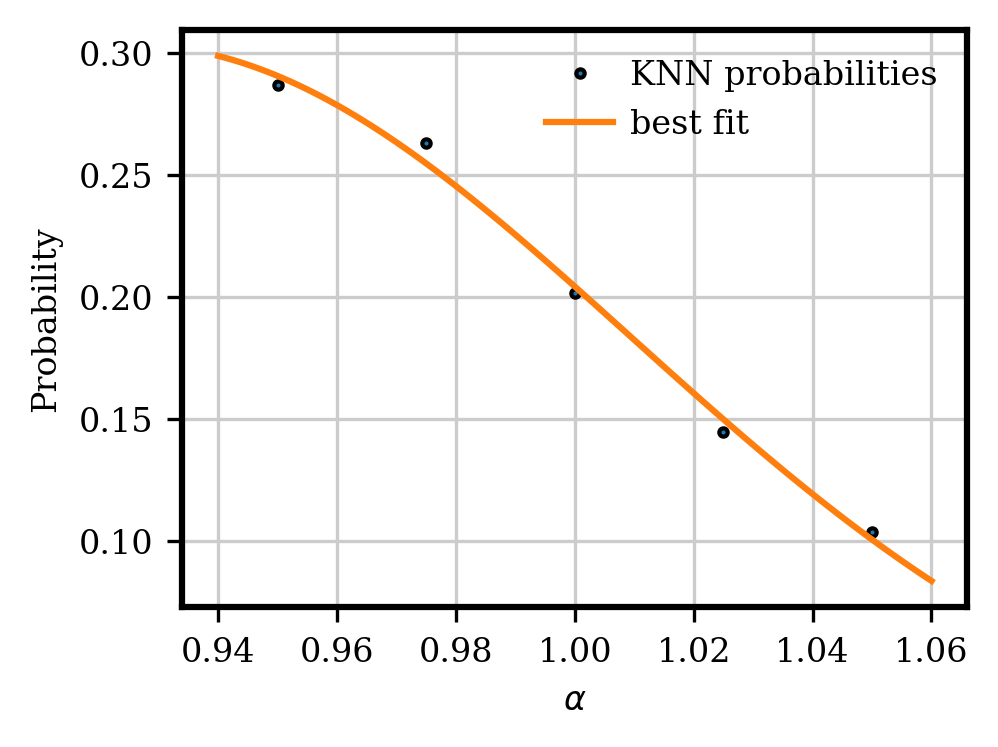

In [18]:
fig, ax = plt.subplots()
plot_one_event(42, ax)
plt.legend()
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Probability")
plt.show()

In [40]:
import matplotlib

def plot_gradient_map(df, grad_name, true_e_binning, reco_e_binning, symmetric=True, ax=None):
    """
    Plot the amplitude of a gradient as a function of the true and reconstructed energy.
    Shows a colormap in the given binning where the color in each bin corresponds to the
    average value of the gradient in that bin.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with the gradient values
    grad_name : str
        Name of the gradient to plot
    true_e_binning : array-like
        Binning of the true energy axis
    reco_e_binning : array-like
        Binning of the reconstructed energy axis
    symmetric : bool, optional
        If True, the colorbar will be symmetric around zero
    ax : matplotlib.axes.Axes, optional
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Calculate the average gradient in each bin
    grad_map, _, _ = np.histogram2d(
        df["true_energy"],
        df["reco_energy"],
        bins=[true_e_binning, reco_e_binning],
        weights=df[grad_name],
    )
    n_entries, _, _ = np.histogram2d(
        df["true_energy"], df["reco_energy"], bins=[true_e_binning, reco_e_binning]
    )
    with np.errstate(divide="ignore", invalid="ignore"):
        grad_map = grad_map / n_entries

    # Plot the gradient map
    if symmetric:
        vmax = np.nanmax(np.abs(grad_map))
        vmin = -vmax
    else:
        vmin = np.nanmin(grad_map)
        vmax = np.nanmax(grad_map)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    im = ax.pcolormesh(
        true_e_binning,
        reco_e_binning,
        grad_map.T,
        cmap="coolwarm",
        # cmap="RdYlBu",
        shading="flat",
        norm=norm,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("True Energy (GeV)")
    ax.set_ylabel("Reconstructed Energy (GeV)")
    return im

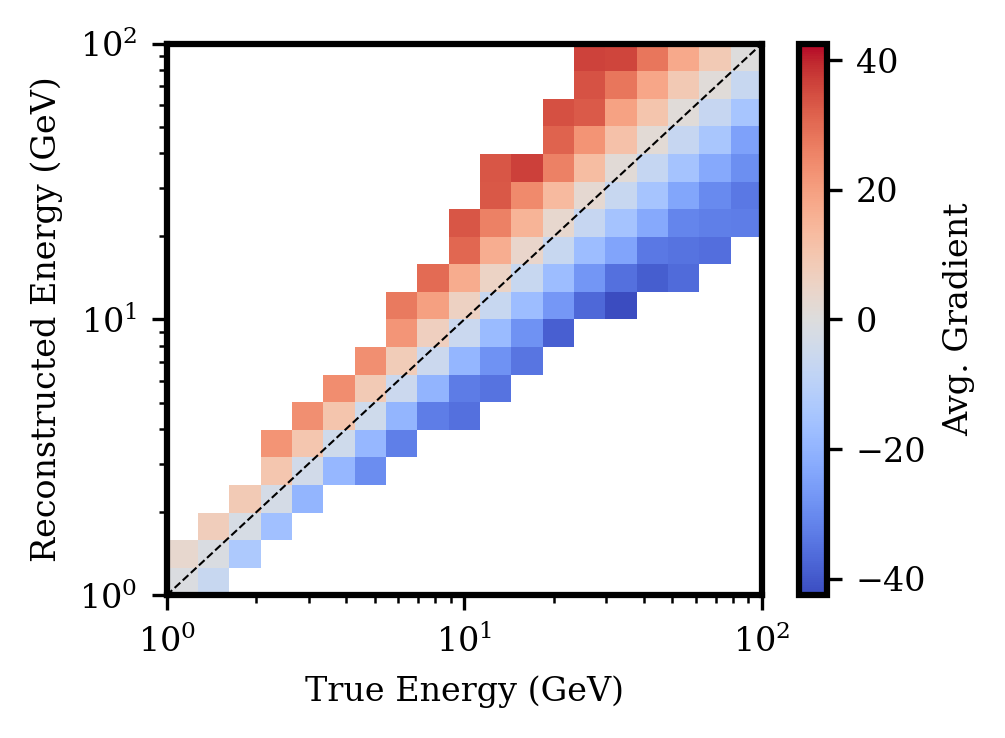

In [41]:
fig, ax = plt.subplots()
im = plot_gradient_map(
    df_with_grads, "grad__mu", np.geomspace(1, 100, 20), np.geomspace(1, 100, 21), ax=ax
)
ax.plot([1, 100], [1, 100], "k--", lw=0.5)
cbar = plt.colorbar(im)
# plt.grid(which="major", axis="both")
cbar.set_label("Avg. Gradient")
plt.tight_layout()
plt.savefig("plot_output/gradient_map.pdf")
plt.show()


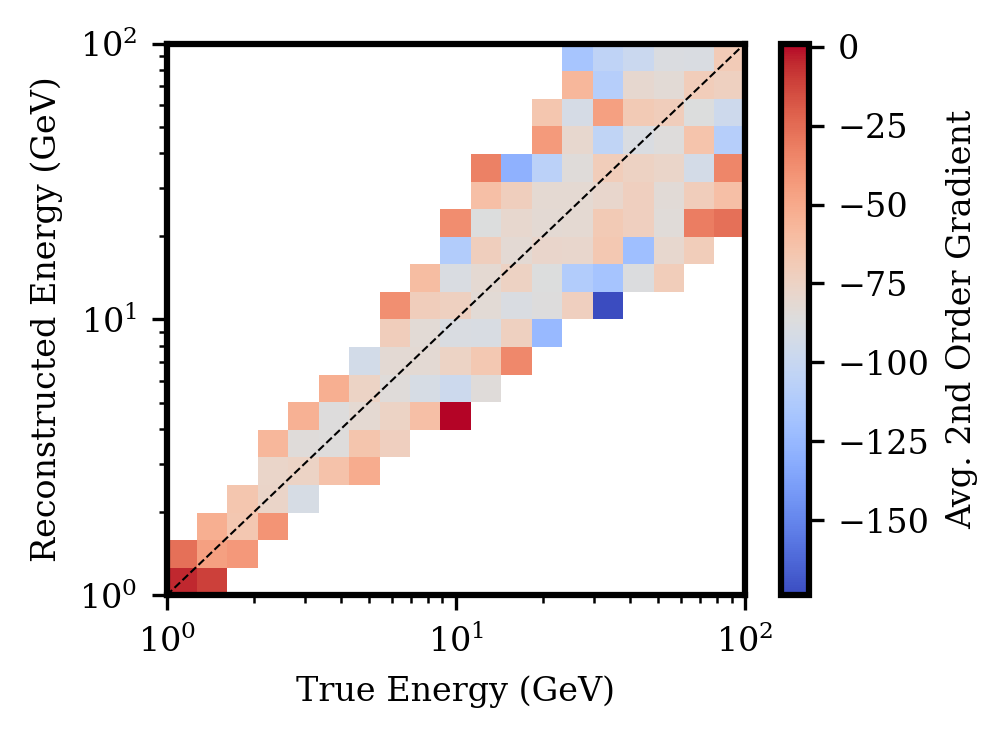

In [42]:
fig, ax = plt.subplots()
im = plot_gradient_map(
    df_with_grads,
    "grad__mu__mu",
    np.geomspace(1, 100, 20),
    np.geomspace(1, 100, 21),
    ax=ax,
    symmetric=False,
)
ax.plot([1, 100], [1, 100], "k--", lw=0.5)
cbar = plt.colorbar(im)
# plt.grid(which="major", axis="both")
cbar.set_label("Avg. 2nd Order Gradient")
plt.tight_layout()
plt.savefig("plot_output/gradient_map_2nd_order.pdf")
plt.show()


In [24]:
from toy_mc.histogram import Histogram


def generate_histogram_at_response(
    df, nominal_response, response, bin_edges, use_systs=None, variable="reco_energy"
):
    """Generate a histogram at a given detector response.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the events and gradients
    nominal_response : toy_mc.generator.Response
        Nominal detector response
    response : toy_mc.generator.Response
        Detector response to weight the events to
    bin_edges : np.ndarray
        Bin edges for the histogram
    use_systs : list of str, optional
        List of systematic names to use. If None, all systematics are used.
    variable : str, optional
        Variable to use for the histogram. Default is "reco_energy".
    """
    if use_systs is None:
        grad_names = df.columns[df.columns.str.startswith("grad__")]
    else:
        grad_names = ["grad_{}".format(syst) for syst in use_systs]
    delta_p = np.ones(len(grad_names))
    for i, grad_name in enumerate(grad_names):
        for param in grad_name.split("grad")[-1].split("__")[1:]:
            delta_p[i] *= getattr(response, param) - getattr(nominal_response, param)
    weights = df["weights"] * np.exp(np.dot(df[grad_names], delta_p))
    hist = Histogram(bin_edges)
    hist.fill(df[variable], weights)
    return hist


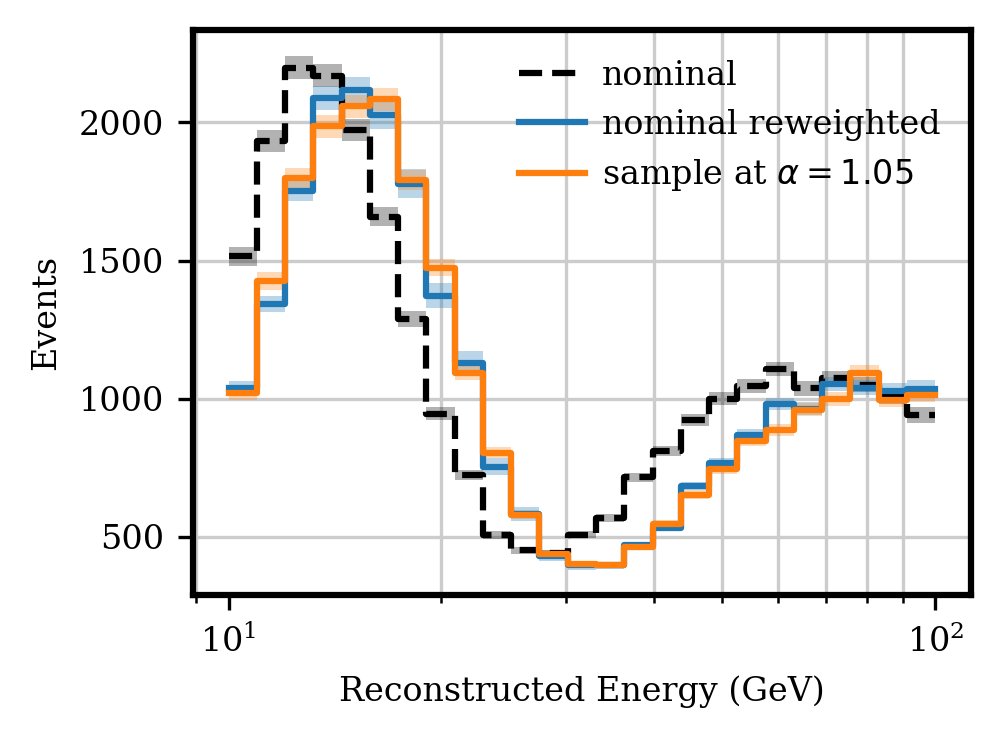

In [26]:
hist_at_sys_01 = generate_histogram_at_response(
    df_with_grads,
    default_response,
    gen_sys_1.detector_response,
    bin_edges
)

gen_sys_1_resampled = generator.Generator(
    int(1e5),
    generator.Response(1.05 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_01",
    rng_seed=42
)
sys_hist = gen_sys_1_resampled.get_histogram(bin_edges)
nominal_hist = gen_nominal.get_histogram(bin_edges)

# plot the histograms
fig, ax = plt.subplots()

plot_histogram(nominal_hist, ax=ax, label="nominal", linestyle="--", color="k")
plot_histogram(hist_at_sys_01, ax=ax, label="nominal reweighted")
plot_histogram(sys_hist, ax=ax, label=r"sample at $\alpha=1.05$")
plt.grid(which="both", axis="x")
plt.xlabel("Reconstructed Energy (GeV)")
plt.ylabel("Events")
plt.semilogx()
plt.legend()
plt.tight_layout()
plt.savefig("plot_output/histogram_at_sys_01.pdf")
plt.show()

In [43]:
# sweep response parameter mu around nominal value and plot the histograms
mus = np.linspace(0.95, 1.05, 200)
hists = []
for mu in mus:
    response = generator.Response(mu * default_response.mu, default_response.sigma)
    hists.append(
        generate_histogram_at_response(
            df_with_grads, default_response, response, bin_edges
        )
    )


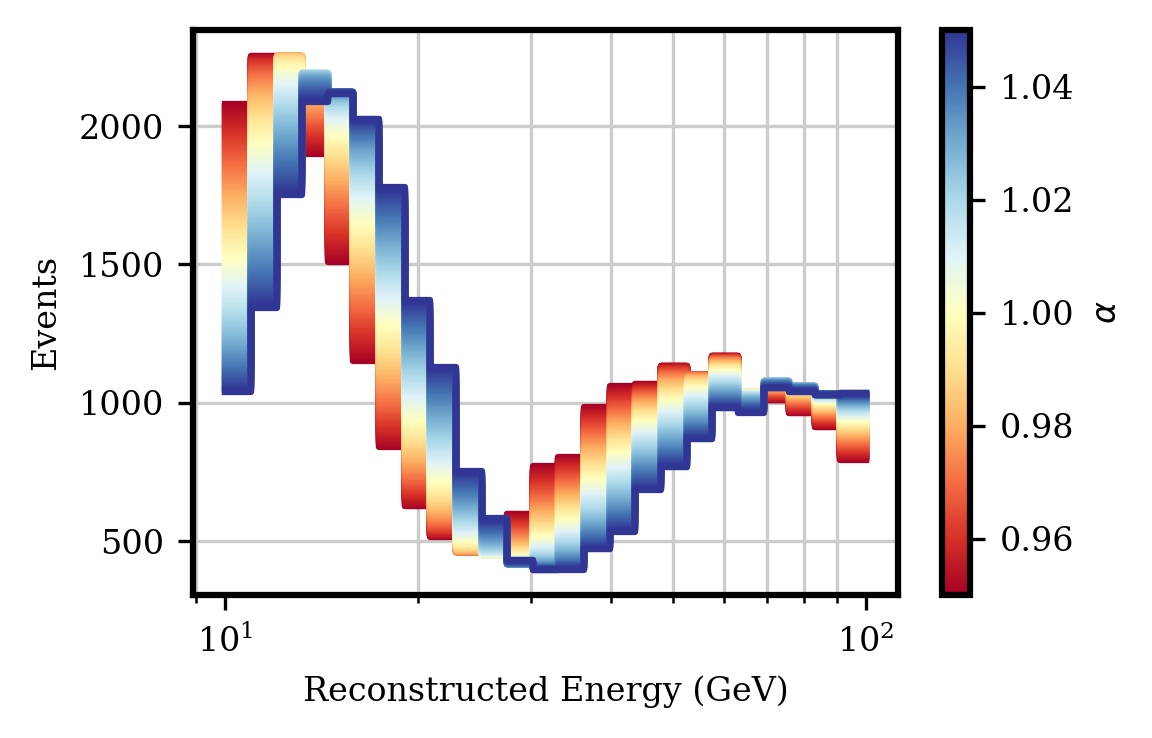

In [50]:
fig, ax = plt.subplots(figsize=(3.875, 2.5))
# make list of colors from a colormap
# colors = plt.cm.viridis(np.linspace(0, 1, len(mus)))
colors = plt.cm.RdYlBu(np.linspace(0, 1, len(mus)))
for hist, mu, color in zip(hists, mus, colors):
    plot_histogram(
        hist,
        ax=ax,
        show_errorband=False,
        label="mu = {}".format(mu),
        color=color,
        rasterized=False,
    )
# make colorbar
sm = plt.cm.ScalarMappable(
    # cmap=plt.cm.viridis,
    cmap=plt.cm.RdYlBu,
    norm=plt.Normalize(vmin=mus.min(), vmax=mus.max())
)
sm._A = []
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\alpha$")
plt.grid(which="both", axis="x")
plt.xlabel("Reconstructed Energy (GeV)")
plt.ylabel("Events")
plt.semilogx()
plt.tight_layout()
plt.savefig("plot_output/histogram_sweep_mu.pdf")
plt.show()


In [29]:
def chi_square(hist1, hist2):
    """Calculate the chi square between two Histogram objects.
    This takes errors into account.
    """
    # get values
    values1 = hist1.hist
    values2 = hist2.hist
    # get errors
    errors1 = hist1.hist_unc
    errors2 = hist2.hist_unc
    # calculate chi square
    chi_square = np.sum((values1 - values2)**2 / (errors1**2 + errors2**2))
    return chi_square

def chi_square_at_response(
    df, nominal_response, response, bin_edges, use_systs=None, variable="reco_energy"
):
    """Calculate the chi square between the nominal and a given detector response."""
    # generate new independent dataset at response with high statistics using new Generator
    gen_response = generator.Generator(
        n_events=int(1e6), response=response, pars=default_pars, rng_seed=42
    )
    # divide by 10 because we have generated 10 times more events
    hist_nominal = gen_response.get_histogram(bin_edges) / 10

    hist_response = generate_histogram_at_response(
        df,
        nominal_response,
        response,
        bin_edges,
        use_systs=use_systs,
        variable=variable,
    )
    return chi_square(hist_nominal, hist_response)


In [30]:
chi2_knn_grads = []
mu_space = np.linspace(0.9, 1.1, 41)
for mu in mu_space:
    test_response = generator.Response(mu, default_response.sigma)
    chi2_knn_grads.append(
        chi_square_at_response(
            df_with_grads, default_response, test_response, bin_edges
        )
    )


[]

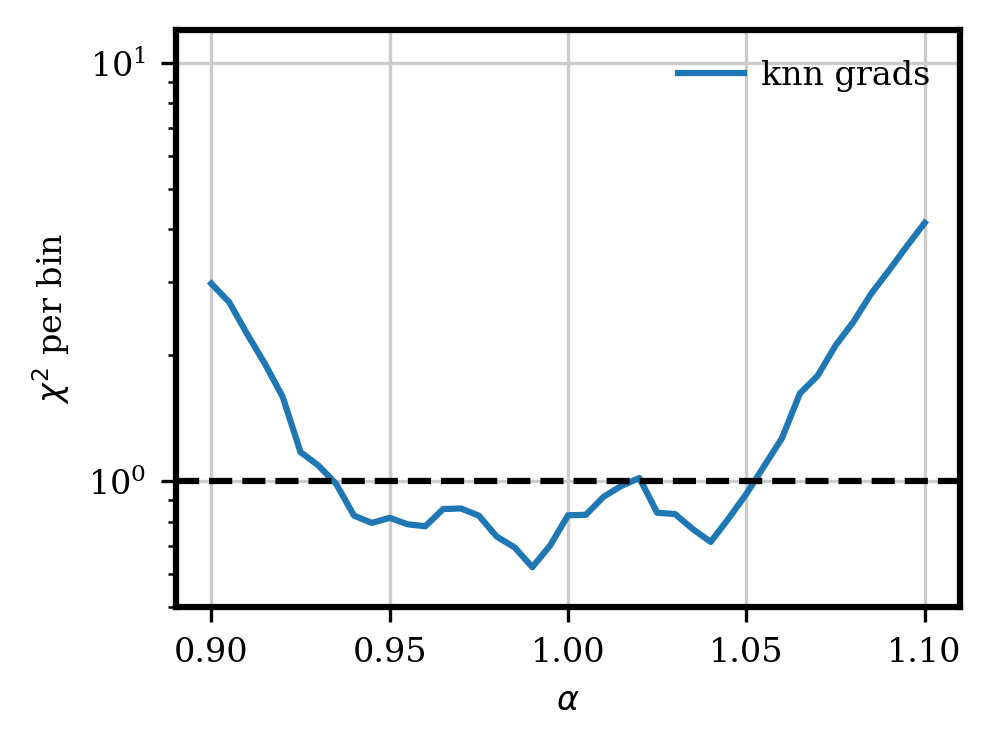

In [31]:
n_bins = len(bin_edges) - 1
plt.plot(mu_space, np.asarray(chi2_knn_grads) / n_bins, label="knn grads")
plt.axhline(1, color="k", linestyle="--")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\chi^2$ per bin")
plt.legend()
plt.ylim(0.5, 12)
plt.semilogy()

### Test different settings of number of neighbors
Repeat the entire process of calculating KNN probabilities and fitting gradients for 
different settings. Then, we make the plot showing chi-square per bin again with
one line for each setting.

In [51]:
import pandas as pd

from typing import List
from toy_mc.generator import Generator


def make_gradients(
    gen_nominal: Generator,
    systematic_generators: List[Generator] = [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables: List[str] = ["true_energy", "reco_energy"],
    tilt_bias_correction: bool = True,
    neighbors_per_class: int = 200,
    systematics: List[str] = ["mu"],
    poly_degree: int = 2,
) -> pd.DataFrame:
    """
    Calculate gradients for a given nominal generator and systematic generators.

    Parameters
    ----------
    gen_nominal : Generator
        The nominal generator.
    systematic_generators : List[Generator], optional
        The list of systematic generators. Defaults to [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4].
    variables : List[str], optional
        The list of variable names to use in the classifier. Defaults to ["true_energy", "reco_energy"].
    tilt_bias_correction : bool, optional
        Whether to perform tilt correction. Defaults to True.
    neighbors_per_class : int, optional
        The number of KNN neighbors per truth class. Defaults to 200.
    systematics : List[str], optional
        The list of systematic types to use in the calculation. Defaults to ["mu"].
    poly_degree : int, optional
        The polynomial degree to fit gradients for. Defaults to 2.

    Returns
    -------
    df_with_grads_output : pd.DataFrame
        A Pandas DataFrame containing the calculated gradients.
    """
    
    # apply KNN
    df_with_probs_tmp = calculate_probs.calculate_probs_sklearn(
        gen_nominal,
        systematic_generators,
        variables=variables,
        tilt_bias_correction=tilt_bias_correction,
        neighbors_per_class=neighbors_per_class,
        jobs=4
    )
    
    # get gradient names for systematic "mu"
    grad_names = calculate_grads.make_gradient_names(systematics, poly_features=poly_degree)
    
    # make delta_p matrix for the systematic "mu" 
    # (i.e. the detector response)
    delta_p = calculate_grads.make_delta_p_from_grad_names(
        grad_names, systematic_generators, gen_nominal
    )
    
    prob_columns = [f"prob_{gen.name}" for gen in [gen_nominal] + systematic_generators]
    
    # Calculate the gradients
    df_with_grads_output = calculate_grads.fit_gradients(
        df_with_probs_tmp, 
        prob_columns=prob_columns, 
        delta_p=delta_p, 
        grad_names=grad_names
    )
    
    return df_with_grads_output


In [52]:
df_with_grads_1000 = make_gradients(
    gen_nominal=gen_nominal,
    systematic_generators=[gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=1000,
    systematics=["mu"],
    poly_degree=2,
)

df_with_grads_200 = make_gradients(
    gen_nominal=gen_nominal,
    systematic_generators=[gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=200,
    systematics=["mu"],
    poly_degree=2,
)

df_with_grads_100 = make_gradients(
    gen_nominal=gen_nominal,
    systematic_generators=[gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=100,
    systematics=["mu"],
    poly_degree=2,
)

df_with_grads_50 = make_gradients(
    gen_nominal=gen_nominal,
    systematic_generators=[gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=50,
    systematics=["mu"],
    poly_degree=2,
)

df_with_grads_20 = make_gradients(
    gen_nominal=gen_nominal,
    systematic_generators=[gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=20,
    systematics=["mu"],
    poly_degree=2,
)

df_with_grads_10 = make_gradients(
    gen_nominal=gen_nominal,
    systematic_generators=[gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=10,
    systematics=["mu"],
    poly_degree=2,
)


Starting KNN evaluation...


100%|██████████| 100000/100000 [01:58<00:00, 845.87it/s]


Starting KNN evaluation...


100%|██████████| 100000/100000 [01:51<00:00, 899.45it/s]


Starting KNN evaluation...


100%|██████████| 100000/100000 [01:01<00:00, 1628.51it/s]


Starting KNN evaluation...


100%|██████████| 100000/100000 [00:50<00:00, 1983.44it/s]


Starting KNN evaluation...


100%|██████████| 100000/100000 [00:49<00:00, 2010.61it/s]


Starting KNN evaluation...


100%|██████████| 100000/100000 [01:02<00:00, 1611.87it/s]


In [54]:
def make_chi2_plot(df, mu_space, bin_edges):
    chi2_knn_grads = []
    for mu in mu_space:
        test_response = generator.Response(mu, default_response.sigma)
        chi2_knn_grads.append(
            chi_square_at_response(
                df, default_response, test_response, bin_edges
            )
        )
    return chi2_knn_grads

In [55]:
chi2_dict = {
    "1000": make_chi2_plot(df_with_grads_1000, mu_space, bin_edges),
    "200": make_chi2_plot(df_with_grads_200, mu_space, bin_edges),
    "100": make_chi2_plot(df_with_grads_100, mu_space, bin_edges),
    "50": make_chi2_plot(df_with_grads_50, mu_space, bin_edges),
    "20": make_chi2_plot(df_with_grads_20, mu_space, bin_edges),
    "10": make_chi2_plot(df_with_grads_10, mu_space, bin_edges),
}

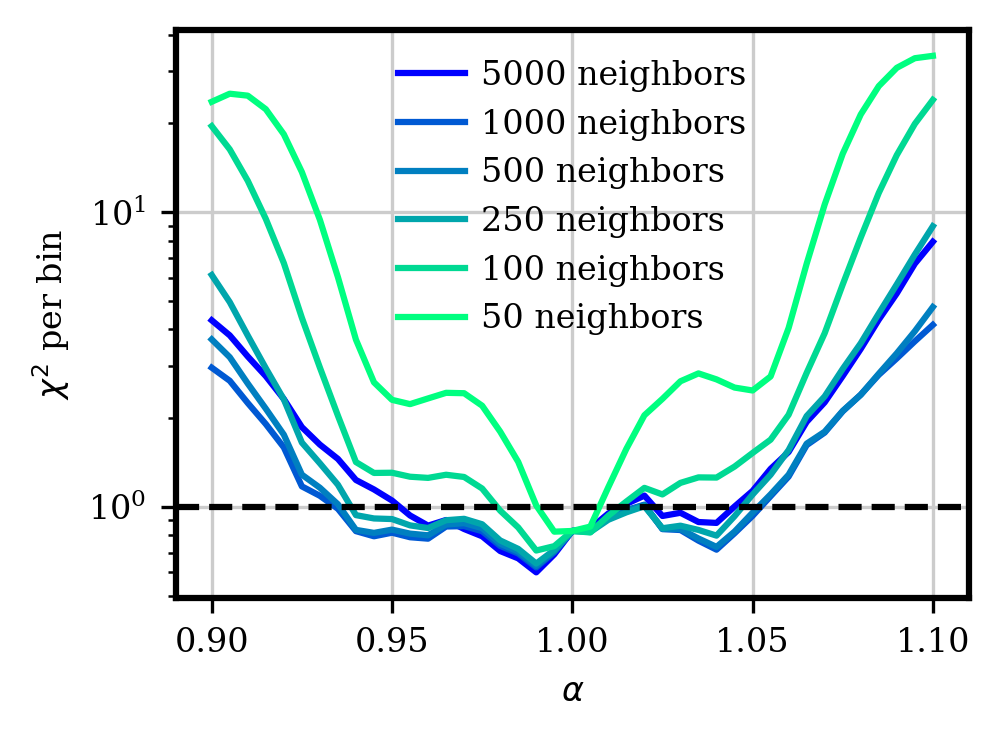

In [65]:
# use a colormap to plot the different number of neighbors
cmap = plt.get_cmap("winter_r")
# cmap = plt.get_cmap("autumn_r")
min_neighbors = np.min([int(n) for n in chi2_dict.keys()]) * 5
max_neighbors = np.max([int(n) for n in chi2_dict.keys()]) * 5 

for n_neighbors in chi2_dict:
    chi2_list = np.asarray(chi2_dict[n_neighbors]) / n_bins
    # compute total number of neighbors, which is n_neighbors * n_classes,
    # where n_classes is 5 for the 4 systematic generators and the nominal
    tot_neighbors = int(n_neighbors) * 5
    color_frac = (np.log10(tot_neighbors) - np.log10(min_neighbors)) / (
        np.log10(max_neighbors) - np.log10(min_neighbors)
    )
    plt.plot(
        mu_space,
        chi2_list,
        label=f"{tot_neighbors} neighbors",
        color=cmap(color_frac),
    )
plt.axhline(1, color="k", linestyle="--")
plt.legend()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\chi^2$ per bin")
plt.semilogy()
plt.tight_layout()
plt.savefig("plot_output/chi2_vs_neighbors.pdf")
plt.show()
